# Разработка моделей машинного обучения для отбора коров к покупке

Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
  * Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
  * Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
  * средний удой за год — не менее 6000 килограммов;
  * молоко должно быть вкусным.

**Цель проекта**:
Разработать две модели машинного обучения для отбора бурёнок в поголовье 

**План проекта**

 1. Загрузка и обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ данных.
 4. Корреляционный анализ признаков в датасете.  
 5. Задача регрессии.
 6. Задача классификации.
 7. Общий выводы.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_absolute_error, 
    mean_squared_error,
    precision_score, 
    r2_score, 
    recall_score, 
)

## Загрузка данных

In [2]:
#считаем данные и загрузим в соответствующие датафреймы
ferma_main = pd.read_csv('ferma_main.csv', sep=';', decimal=',')
ferma_dad = pd.read_csv('ferma_dad.csv', sep=';')
cow_buy = pd.read_csv('cow_buy.csv', sep=';', decimal=',')

In [3]:
#создадим функцию для вывода общей информации о датасете
def main_info(data):
    display(data.head())
    data.info()
    return 

In [4]:
#выведем общую информацию о первом датасете
main_info(ferma_main)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

По выводу можем увидеть, что тип данных соответствует ожидаемому. Пропусков в данных нет, названия столбцов нужно привести к стандартному. 

In [5]:
#изменим наименования столбцов
ferma_main = ferma_main.rename(
    columns ={
        'Удой, кг': 'удой', 
        'ЭКЕ (Энергетическая кормовая единица)': 'эке', 
        'Сырой протеин, г': 'сырой_протеин', 
        'СПО (Сахаро-протеиновое соотношение)': 'спо',
        'Порода': 'порода',
        'Тип пастбища': 'тип_пастбища',
        'порода папы_быка': 'порода_папы_быка',
        'Жирность,%': 'жирность',
        'Белок,%': 'белок',
        'Вкус молока': 'вкус_молока',
        'Возраст': 'возраст',
    }
)

#проверим изменения 
ferma_main.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [6]:
#выведем общее инфо о датасете с информацией об имени папы коров в стаде фермера
main_info(ferma_dad)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Тип данных соответствует ожидаемому. Пропусков в данных нет, названия столбцов нужно привести к стандартному. 

In [7]:
#приведем наименования столбцов к нижнему регистру
ferma_dad = ferma_dad.rename(
    columns ={
        'Имя Папы': 'имя_папы', 
    }
)

#проверим изменения
ferma_dad.head()

,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [8]:
#выведем общее инфо о датасете с коровами к покупке
main_info(cow_buy)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Типы данных соответствуют ожидаемым, пропусков в данных нет, наименования столбцов нужно привести к стандартному. 

In [9]:
#изменим наименования столбцов
cow_buy = cow_buy.rename(
    columns ={
        'Порода': 'порода',
        'Тип пастбища': 'тип_пастбища',
        'порода папы_быка': 'порода_папы_быка',
        'Имя_папы': 'имя_папы',
        'Текущая_жирность,%': 'жирность',
        'Текущий_уровень_белок,%': 'белок',
        'Возраст': 'возраст',
    }
)

#проверим изменения
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Провели загрузку и обзор данных, в данных нет пропусков и типы данных соответствуют ожидаемым. Провели замену названия столбцов. 

## Предобработка данных

Проверим данные на наличие пропусков и дубликатов. 

### Обработка ferma_main

In [10]:
#выведем все уникальные значения в столбцах первого датасета
ferma_main.apply(lambda x: x.unique())

id                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
удой                [5863, 5529, 5810, 5895, 5302, 5254, 5910, 617...
эке                 [14.2, 12.8, 14.0, 12.4, 12.7, 13.2, 14.7, 13....
сырой_протеин       [1743, 2138, 1854, 2012, 1675, 1806, 1792, 191...
спо                 [0.89, 0.885, 0.93, 0.94, 0.895, 0.95, 0.96, 0...
порода                              [Вис Бик Айдиал, РефлешнСоверинг]
тип_пастбища                        [Равнинное, Равнинные, Холмистое]
порода_папы_быка                           [Айдиал, Соверин, Айдиалл]
жирность            [3.58, 3.54, 3.59, 3.4, 3.73, 3.13, 3.48, 3.55...
белок               [3.076, 3.079, 3.074, 3.075, 3.073, 3.078, 3.0...
вкус_молока                                       [вкусно, не вкусно]
возраст                                    [более_2_лет, менее_2_лет]
dtype: object

Видим неявные дубликаты в строках о породе, типе пастбища и породе папы быка. Напишем функцию для замены дубликатов в строках

In [11]:
#подготовка данных для замены 
dict = {
    'РефлешнСоверинг': 'Рефлешн Соверинг',
    'Равнинное': 'равнинное',
    'Равнинные': 'равнинное', 
    'Холмистое': 'холмистое',
    r'^Айдиал\b': 'Вис Бик Айдиал',
    'Айдиалл': 'Вис Бик Айдиал',
    r'^Соверин\b': 'Рефлешн Соверинг'
}

In [12]:
#создадим функцию для замены
def rename(data):
    for col_name in ['порода', 'тип_пастбища', 'порода_папы_быка']:
        for key, val in dict.items():
            data[col_name] = data[col_name].str.replace(key, val, regex=True)
    return data
  

In [13]:
#внесем изменения в первый датасет
rename(ferma_main)  

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,Рефлешн Соверинг,холмистое,Рефлешн Соверинг,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,Рефлешн Соверинг,холмистое,Вис Бик Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
629,627,5970,14.4,1837,0.880,Рефлешн Соверинг,холмистое,Рефлешн Соверинг,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.880,Рефлешн Соверинг,холмистое,Рефлешн Соверинг,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.880,Рефлешн Соверинг,холмистое,Рефлешн Соверинг,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.880,Рефлешн Соверинг,холмистое,Рефлешн Соверинг,3.64,3.075,не вкусно,более_2_лет


In [14]:
#проверим датасет на наличие явных дубликатов
ferma_main.duplicated().sum()

5

In [15]:
#удалим найденные дубликаты
ferma_main = ferma_main.drop_duplicates()

### Обработка ferma_dad

In [16]:
#выведем все уникальные значения в столбцах датасета
ferma_dad['имя_папы'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [17]:
ferma_dad.duplicated().sum()

0

Данные во втором датасете без дубликатов

### Обработка cow_buy

In [18]:
#выведем все уникальные значения в столбцах третьего датасета
cow_buy.apply(lambda x: x.unique())

порода                              [Вис Бик Айдиал, РефлешнСоверинг]
тип_пастбища                                   [холмистое, равнинное]
порода_папы_быка                                    [Айдиал, Соверин]
имя_папы                          [Геркулес, Буйный, Барин, Соловчик]
жирность            [3.58, 3.54, 3.59, 3.4, 3.64, 3.63, 3.57, 3.73...
белок               [3.076, 3.081, 3.074, 3.061, 3.053, 3.079, 3.0...
возраст                                    [более_2_лет, менее_2_лет]
dtype: object

In [19]:
#заменим все неявные дубликаты в датасете
rename(cow_buy)

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,Буйный,3.54,3.081,менее_2_лет
2,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,Барин,3.59,3.074,более_2_лет
3,Рефлешн Соверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет
4,Рефлешн Соверинг,равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет
5,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,Буйный,3.57,3.079,более_2_лет
8,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,Барин,3.59,3.074,более_2_лет
9,Рефлешн Соверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.079,менее_2_лет


In [20]:
#проверим наличие дубликатов
cow_buy.duplicated().sum()

4

Так как датасет с информацией о коровах к покупке достаточно маленький, будем считать, что подобные дубликаты возможны и оставим датасет без изменений

### Вывод

Были удалены и заменены все явные и неявные дубликаты, в датасете с информацией о коровах к покупке было решено оставить дубликаты без изменений. Не были выявлены некорректные типы данных и пропуски в датасетах. 

## Исследовательский анализ данных

Проведем статистический анализ всех признаков.
Построим графики для каждого признака. 
Сделаем выводы о данных: 
замечены ли вы выбросы, необычное распределение количественных признаков или другие особенности;
план об улучшении данных.

### Построение графиков для количественных признаков

In [21]:
#разделим признаки на категориальные и количественные
num_col_names = ['удой', 'эке', 'сырой_протеин', 'спо', 'жирность', 'белок']
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']

#подготовим названия осей
labels = ['Масса молока, которую корова даёт в год, кг',
          'ЭКЕ, показатель питательности корма коровы',
          'Содержание сырого протеина в корме, г',
          'СПО, отношение сахара к протеину в корме коровы',
          'Содержание жиров в молоке, %',
          'Содержание белка в молоке, %'
         ]

In [22]:
#выведем общее описание количечественных признаков
ferma_main[num_col_names].describe().T

,count,mean,std,min,25%,50%,75%,max
удой,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000
эке,629.0,14.543879,1.306408,10.900,13.500,14.700,15.600,16.800
сырой_протеин,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000
спо,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960
жирность,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750
белок,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085


Можно заметить аномальное максимальное значение удоя - 45616 кг при средних значениях 6188кг - посмотрим графики и примем решение об удалении выбросов

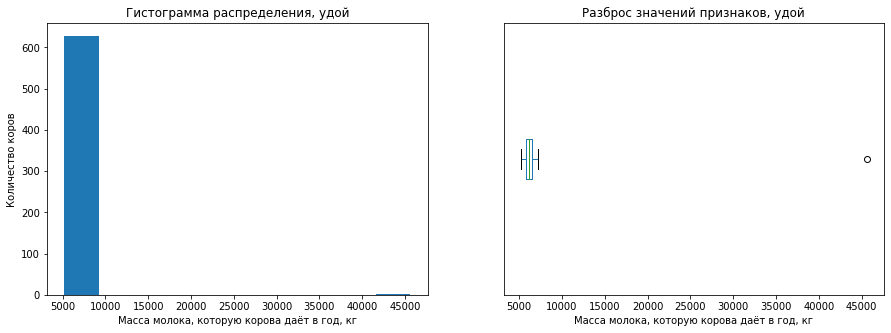

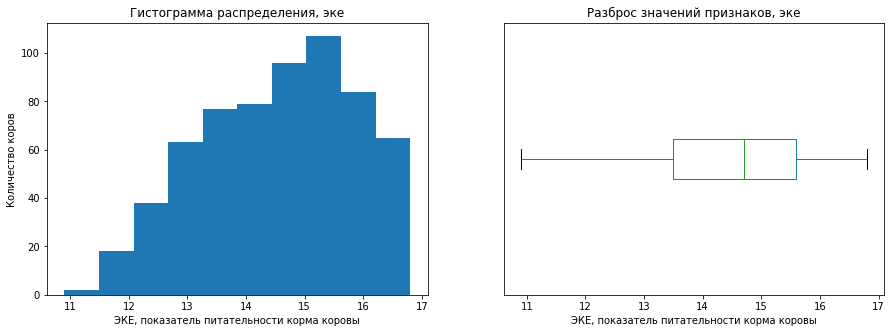

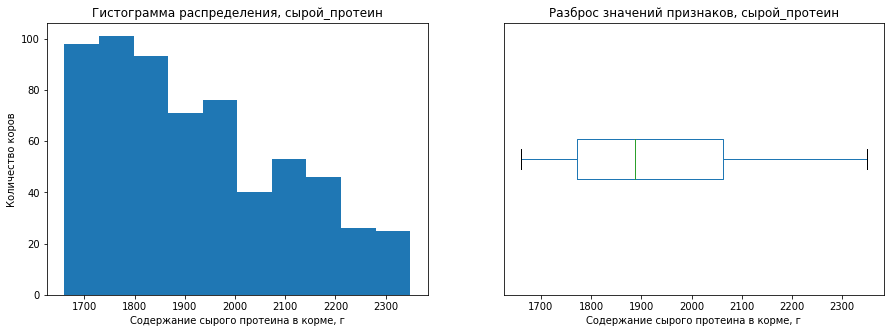

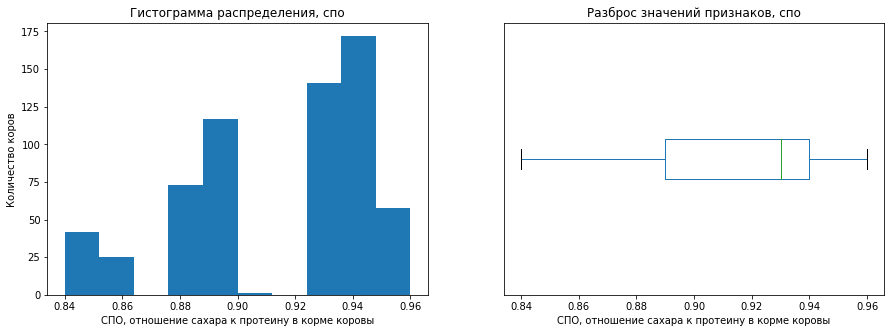

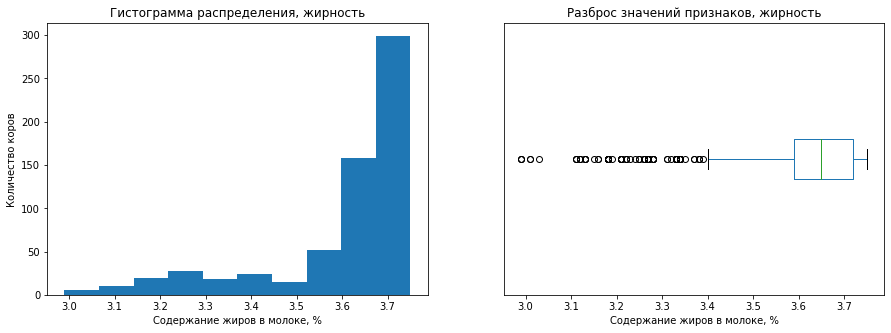

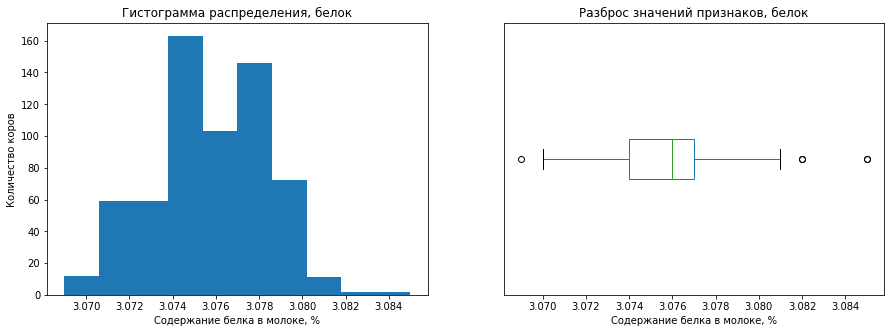

In [23]:
#построение графиков для количественных признаков
for i, col_name in enumerate(num_col_names):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ferma_main[col_name].plot(kind='hist', bins=10, ax=axes[0])
    axes[0].set_title(f'Гистограмма распределения, {col_name}')
    axes[0].set_xlabel(f'{labels[i]}')
    axes[0].set_ylabel('Количество коров')
    ferma_main[col_name].plot(kind='box', ax=axes[1], vert=False)
    axes[1].set_title(f'Разброс значений признаков, {col_name}')
    axes[1].set_xlabel(f'{labels[i]}')
    axes[1].set_yticks([])
    plt.show()

На графике удоя видим, что замеченное аномальное значение - выброс, устраним его. 
Распределения ЭКЕ и белка похожи на нормальные, есть небольшое смещение (влево и вправо).
На графике белка и жирности также видим выбросы - оставим данные для последующего анализа. 
Графики распредления сырого протеина и СПО не похожи на нормальные, необходимо изменить признаки для улучшения связи с целевым признаком


In [24]:
#устраним выброс в данных с удоем
ferma_main = ferma_main.query('удой <10000')

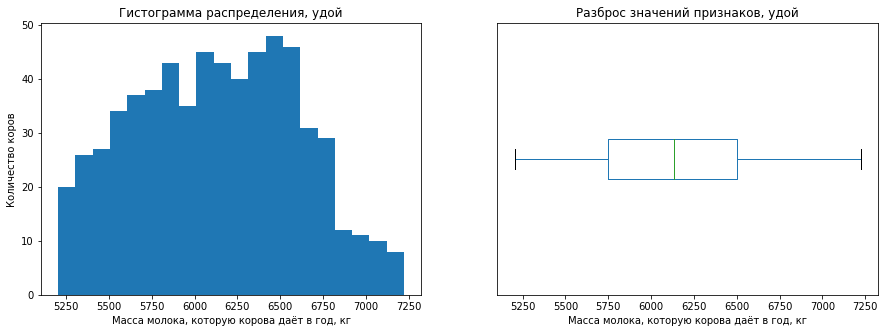

In [25]:
#построим график целевого признака
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ferma_main['удой'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title(f'Гистограмма распределения, удой')
axes[0].set_xlabel(f'{labels[0]}')
axes[0].set_ylabel('Количество коров')
ferma_main['удой'].plot(kind='box', ax=axes[1], vert=False)
axes[1].set_title(f'Разброс значений признаков, удой')
axes[1].set_xlabel(f'{labels[0]}')
axes[1].set_yticks([])
plt.show()

Распределение значений удоя коров похоже на нормальное, данных со значениями удоя выше 6500 кг меньше, чем данных о небольшом удое - может повлиять на прогноз моделей. Для прогнозов высокого удоя необходимо больше данных о таких показателях в стаде

### Построение графиков для категориальных признаков

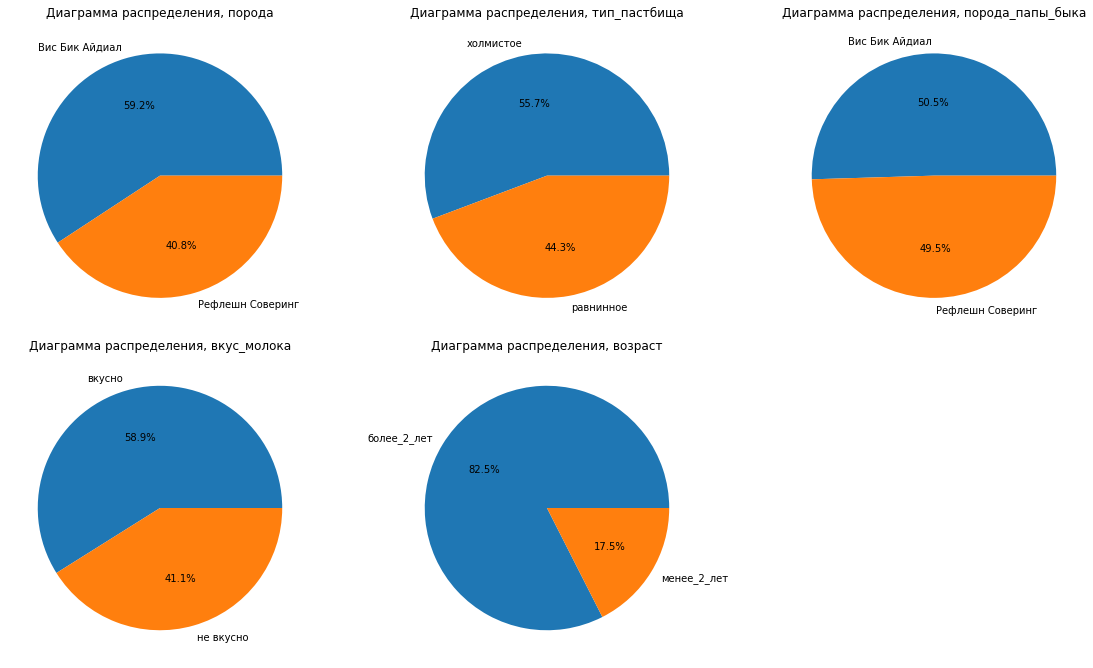

In [26]:
#построим круговые диаграммы для признаков
i = 1
fig, ax = plt.subplots()
for col_name in cat_col_names:
    ax = plt.subplot(3, 3, i)
    ferma_main[col_name].value_counts().plot(kind='pie', autopct='%.1f%%', ax=ax, figsize=(16, 14))
    i +=1
    ax.set_title(f'Диаграмма распределения, {col_name}')
    ax.set_ylabel('')
fig.tight_layout()  
plt.show() 
         

Все признаки достаточно равномерно распределены в выборке. Но в данных больше записей со взрослыми коровами - также может повлиять на прогноз модели, скорее всего будут ошибки при прогнозе для молодых коров. 

### Вывод

Были построены графики распределения количественных и категориальных признаков в выборке. 
Замечены выбросы в целевом признаке - удое, а также в значениях белка, жирности молока коров. 
Есть основания полагать, что модель будет плохо работать с данными о высоких показаниях удоя, а также с данными о молодых коровах - так как их достаточно мало относительно других записей в датасете  

## Корреляционный анализ

Проведем корреляционный анализ признаков в датасете ferma_main.csv
Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками.
Построим диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков. 
Сделаем выводы о взаимосвязи признаков. 
Определим тип взаимосвязи между целевым и входными признаками и необходимость введения дополнительных признаков для корректировки нелинейных связей.
Отследим наличие мультиколлинеарности между входными признаками.


### Взаимосвязь между признаками

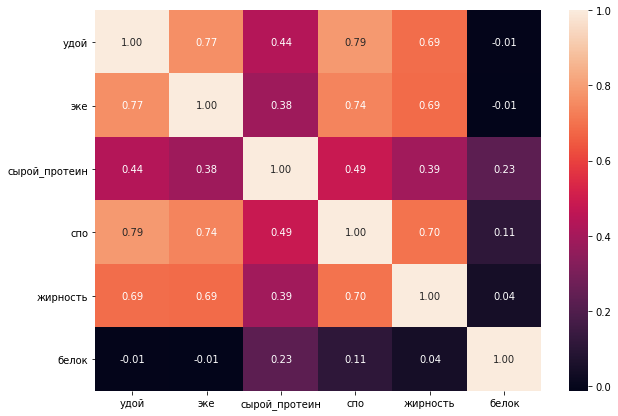

In [27]:
#построим график со значениями корреляции между всеми признаками
fig, axes = plt.subplots(figsize=(10,7))
ax = sns.heatmap(ferma_main.iloc[:, 1:].corr(method='spearman'), annot=True, fmt='.2f')

plt.show()

Так как выше было замечено, что не все признаки распределены нормально, использовали корреляцию Спирмана для подсчета связей между признаками. 

По графику можем увидеть наличие высокой связи между удоем и ЭКЕ, СПО. 
Заметная связь между удоем и жирностью молока, умеренная - между удоем и сырым протеином в корме коров. 
Отсутствует связь между белком и удоем молока. 
Существует высокий уровень связи между показателями ЭКЕ и СПО, между СПО и жирностью молока, умеренный - между ЭКЕ и жирностью молока. 
В общем можно отметить, что между входными признаками нет мультиколиннеарности.

### Диаграммы рассеяния

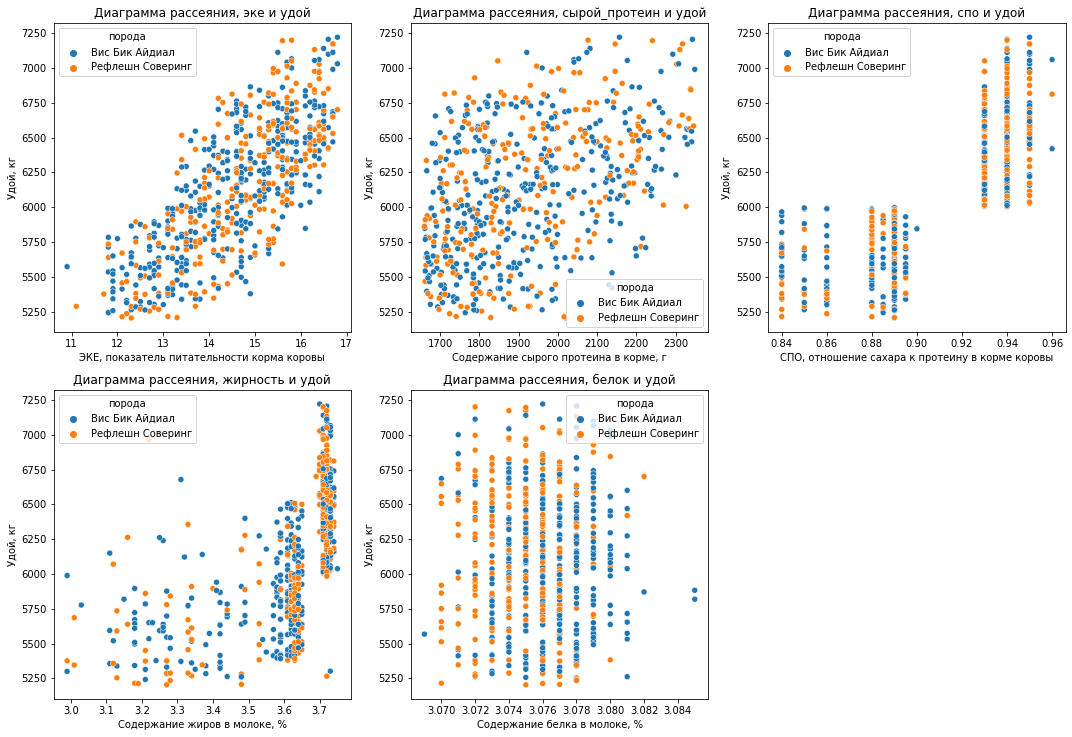

In [28]:
#построим диаграммы рассеяния для целевого признака и всех количественных признаков с учётом значения породы коровы
fig, ax = plt.subplots(figsize=(15,15))
for i, col_name in enumerate(num_col_names[1:], 1):
    ax = plt.subplot(3, 3, i)
    sns.scatterplot(data=ferma_main, x=col_name, y='удой', hue='порода', ax=ax)
    ax.set_title(f'Диаграмма рассеяния, {col_name} и удой')
    ax.set_xlabel(f'{labels[i]}')
    ax.set_ylabel('Удой, кг')
fig.tight_layout()  
plt.show() 


На графиках можем увидеть, что мвязь между удоем и количественными признаками не линейная. Между ЭКЕ и удоем молока отслеживается связь, похожая по графику на квадратичную функцию. График СПО и жирности молока похож на график категориального признака. Нет различий в взаимосвязях для разных пород.  

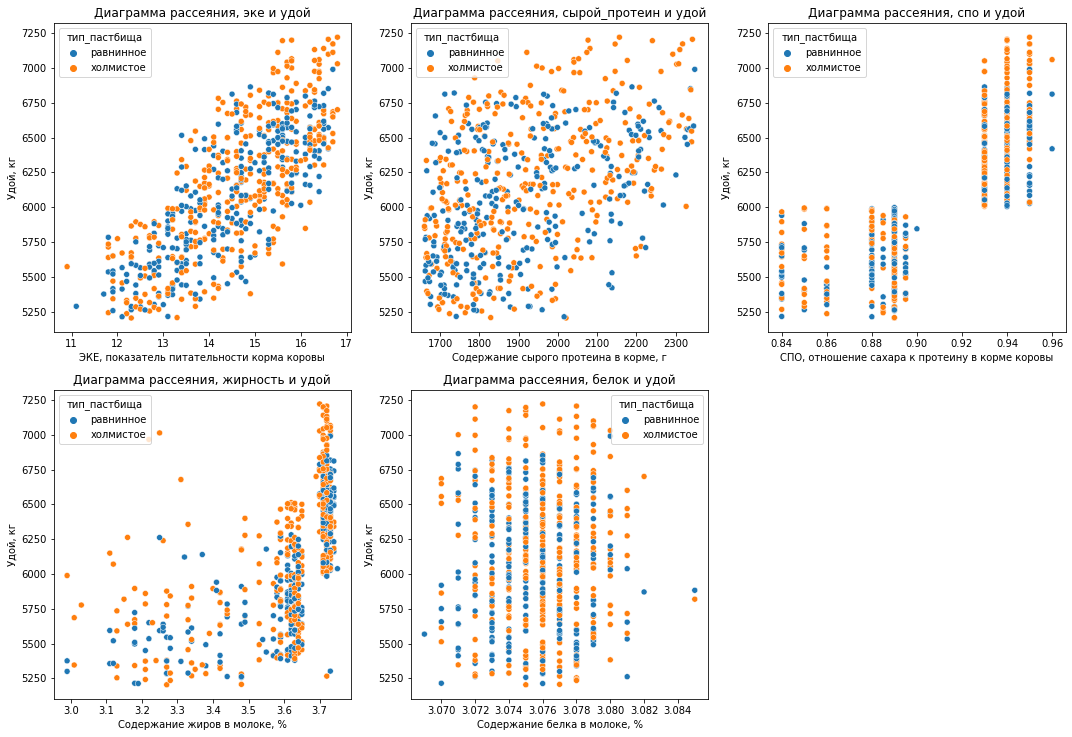

In [29]:
#построим диаграммы рассеяния для целевого признака и всех количественных признаков с учётом значения типа пастбища
fig, ax = plt.subplots(figsize=(15,15))
for i, col_name in enumerate(num_col_names[1:], 1):
    ax = plt.subplot(3, 3, i)
    sns.scatterplot(data=ferma_main, x=col_name, y='удой', hue='тип_пастбища', ax=ax)
    ax.set_title(f'Диаграмма рассеяния, {col_name} и удой')
    ax.set_xlabel(f'{labels[i]}')
    ax.set_ylabel('Удой, кг')
fig.tight_layout()  
plt.show() 


Здесь можем заметить, что коровы, обитающие на холмистых пастбищах дают более высокие показатели удоя при практически равных показателях питания и жирности молока. 
Но характер связи с удоем все еще не различается для разных типов пастбищ

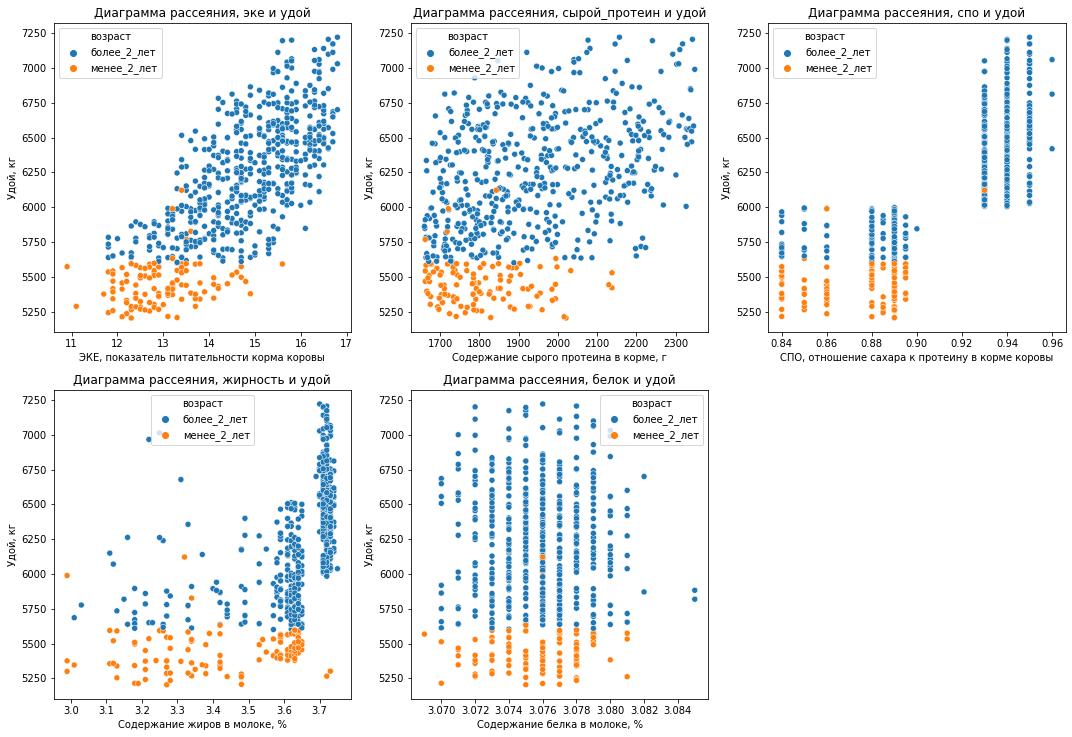

In [30]:
#построим диаграммы рассеяния для целевого признака и всех количественных признаков с учётом значения возраста коровы

fig, ax = plt.subplots(figsize=(15,15))
for i, col_name in enumerate(num_col_names[1:], 1):
    ax = plt.subplot(3, 3, i)
    sns.scatterplot(data=ferma_main, x=col_name, y='удой', hue='возраст', ax=ax)
    ax.set_title(f'Диаграмма рассеяния, {col_name} и удой')
    ax.set_xlabel(f'{labels[i]}')
    ax.set_ylabel('Удой, кг')
fig.tight_layout()  
plt.show() 


На графиках видим, что показатели низкого удоя обеспечивают коровы возраста менее 2х лет. 
Также для молодых коров отсутствует взаимосвязь с удоем, в то время как у взрослых коров эта связь появляется. 

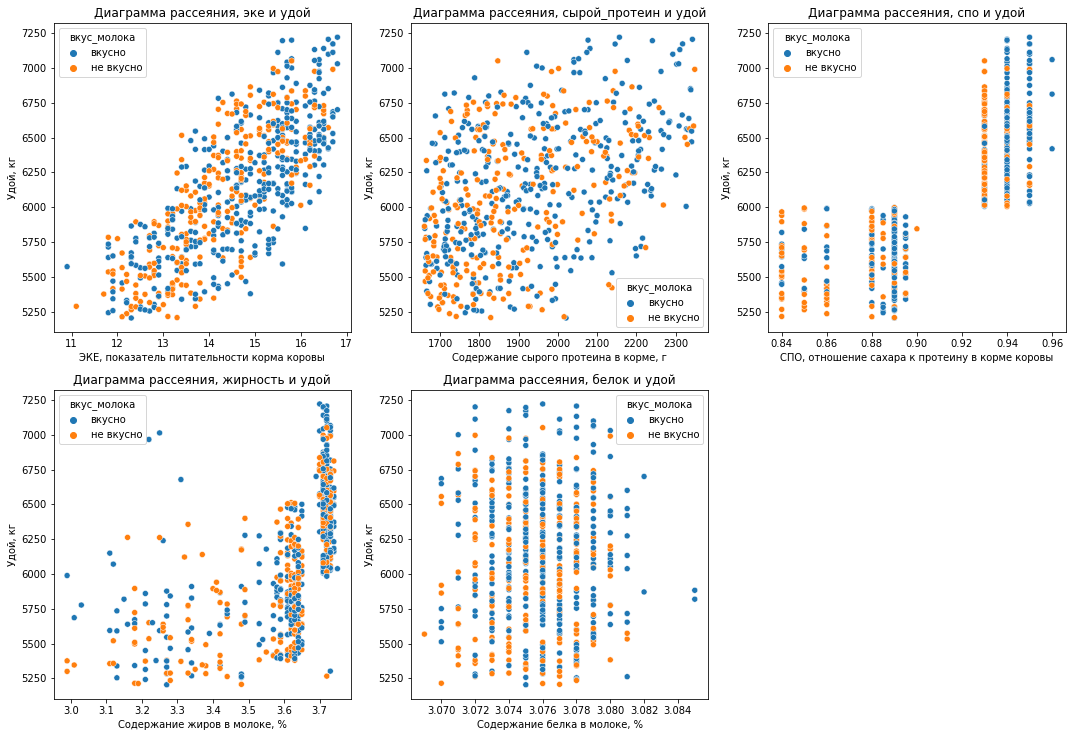

In [31]:
fig, ax = plt.subplots(figsize=(15,15))
for i, col_name in enumerate(num_col_names[1:], 1):
    ax = plt.subplot(3, 3, i)
    sns.scatterplot(data=ferma_main, x=col_name, y='удой', hue='вкус_молока', ax=ax)
    ax.set_title(f'Диаграмма рассеяния, {col_name} и удой')
    ax.set_xlabel(f'{labels[i]}')
    ax.set_ylabel('Удой, кг')
fig.tight_layout()  
plt.show() 


Здесь можем отметить, что молоко, которое фермер считает вкусным имеет комплексный характер, нет возможности отметить важные связи с другими признаками. 

### Вывод

По графику увидели наличие высокой связи между удоем и ЭКЕ, СПО. Заметная связь между удоем и жирностью молока, умеренная - между удоем и сырым протеином в корме коров. Отсутствует связь между белком и удоем молока. Существует высокий уровень связи между показателями ЭКЕ и СПО, между СПО и жирностью молока, умеренный - между ЭКЕ и жирностью молока. В общем можно отметить, что между входными признаками нет мультиколиннеарности.

Построили график корреляции между признаками, расчитав показатель по методу Спирмана (выбран данный метод, так как не все признаки распределены нормально) 

На графиках можем увидеть, что связь между удоем и количественными признаками не линейная. Между ЭКЕ и удоем молока зависимость по графику похожа на квадратичную. График СПО и жирности молока похож на график категориального признака. Нет различий в взаимосвязях для разных пород.

Коровы, обитающие на холмистых пастбищах дают более высокие показатели удоя при практически равных показателях питания и жирности молока. Но характер связи с удоем все еще не различается для разных типов пастбищ.

Для молодых коров будет сложно предсказать показатели удоя и вкуса молока - так как взаимосвязь с другими признаками не прослеживается. 

Связи с целевым признаком в общем нелинейные, необходимо ввести новые признаки или транформировать текущие для приближения связи к линейной. 

## Обучение модели линейной регрессии

### Первая модель линейной регрессии

Необходимо подготовить данные датасета ferma_main.csv и обучить на них первую модель LinearRegression. 
Используем в качестве целевого признак Удой, кг.

In [32]:
def linreg_preproc(data):
    RANDOM_STATE = 42
    X = data.drop(['удой'], axis=1)
    y = data['удой']
    
    X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])
    
    encoder = OneHotEncoder(drop='first', sparse=False)
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    encoder_col_names = encoder.get_feature_names()

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    return X_train, X_test, y_train, y_test

In [33]:
#создание константы RANDOM_STATE
RANDOM_STATE = 42

# выделяем в отдельные переменные целевой признак и входные признаки
X = ferma_main.drop(['удой'], axis=1)
y = ferma_main['удой']

# разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)


Выберем следующие признаки для модели линейной регрессии:
ЭКЕ, СПО, сырой протеин - признаки, связанные с кормом - могут напрямую влиять на размер удоя. 
Порода, порода папы-быка и возраст - биологические признаки, которые могут как напрямую так и наследственно влиять на размер удоя. Тип пастбища - увидели на диаграмме рассеяния, что этот признак также неким образом связан с удоем.
Признаки, связанные с молоком: белок, жирность, не могут влиять на удой, так как эти признаки являются уже следствием удоя молока. 


In [34]:
#разделим отобранные признаки на категориальные и количественные
num_col_names = ['эке', 'сырой_протеин', 'спо']
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']

Масштабируем количественные признаки с помощью StandardScaler

In [35]:
#создаем переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

#обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

#выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[num_col_names])

Кодируем категориальные признаки с помощью OneHotEncoder.

In [36]:
#создаем переменную с экземпляром класса OneHotEncoder()
encoder = OneHotEncoder(drop='first', sparse=False)

#обучим и трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

#выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[cat_col_names])

#получим от кодировщика список новых столбцов 
encoder_col_names = encoder.get_feature_names()


Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

In [37]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

#объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#проверим изменения
X_train[:5]

,x0_Рефлешн Соверинг,x1_холмистое,x2_Рефлешн Соверинг,x3_менее_2_лет,эке,сырой_протеин,спо
0,1.0,1.0,1.0,0.0,1.502378,1.079523,0.837130
1,1.0,1.0,1.0,1.0,-1.557270,-0.196920,-0.703660
2,0.0,0.0,0.0,0.0,0.125537,-1.386085,-1.011818
3,0.0,1.0,0.0,0.0,-0.103937,0.752230,0.837130
4,0.0,0.0,0.0,0.0,-1.098323,0.828598,-0.703660


Обучим модель линейной регрессии на подготовленных данных.

In [38]:
#инициализируем модель линейной регрессии
model_lr_1  = LinearRegression()

#обучим модель на тренировочных данных
model_lr_1.fit(X_train, y_train)

#получим предсказания модели на тестовых данных 
predictions_1 = model_lr_1.predict(X_test)

Оценим качество модели на тестовой выборке

In [39]:
r2_1 = r2_score(y_test, predictions_1)
print(f'R2 LinearRegression = {r2_1:.3f}')

R2 LinearRegression = 0.784


In [40]:
mse_1 = mean_squared_error(y_test, predictions_1)
print(f'MSE LinearRegression = {mse_1:.3f}')

MSE LinearRegression = 43887.015


In [41]:
rmse_1 = mean_squared_error(y_test, predictions_1, squared=False)
print(f'RMSE LinearRegression = {rmse_1:.3f}')

RMSE LinearRegression = 209.492


In [42]:
mae_1 = mean_absolute_error(y_test, predictions_1)
print(f'MAE LinearRegression = {mae_1:.3f}')

MAE LinearRegression = 164.242


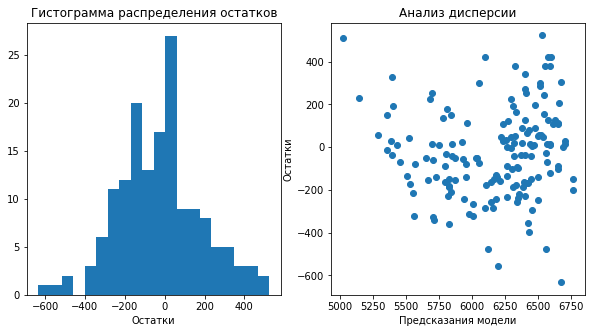

In [43]:
# проведем анализ остатков
# перед этим рассчитаем остатки
residuals_1 = y_test - predictions_1

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_1, bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_1, residuals_1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Значение R² первой модели = 0.784, то есть примерно в 78% случаев предсказание модели ближе к истинному значению, чем среднее значение целевого признака. 

На графике распределения остатков видим, что распределение нормальное, сумма остатков близка к нулю, то есть модель достаточно хорошо работает. 

По графику дисперсии видим, что разница между минимум и максимумом остатков на высоких прогнозных значениях больше, чем на низких значениях прогноза. 

Можно попробовать добавить в модель дополнительные признаки или трансформировать данные, чтобы изменить взаимосвязь входных признаков с целевым. 

### Вторая модель линейной регрессии

Необходимо подготовить данные с учётом связи входных признаков с целевым и обучить на них вторую модель линейной регрессии. 

Попробуем исключить нелинейность связей признаков с целевым.
Преобразуем СПО в категориальный бинарный признак, использовав границу между двумя кластерами из диаграммы рассеяния. 
Также введем два новых признака: ЭКЕ в квадрате и сахар состава корма.

In [44]:
#введем новые признаки
ferma_main['спо_01'] = ferma_main['спо'].apply(lambda x: 'меньше_0.92' if x < 0.92 else 'больше_0.92')
ferma_main['эке_квадрат'] = ferma_main['эке'].apply(lambda x: x**2)
ferma_main['сахар'] = ferma_main['спо'] * ferma_main['сырой_протеин']

#создание константы RANDOM_STATE
RANDOM_STATE = 42

#выделим в отдельные переменные целевой признак и входные признаки
X = ferma_main.drop(['удой'], axis=1)
y = ferma_main['удой']

#разделим данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)
ferma_main

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,спо_01,эке_квадрат,сахар
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.58,3.076,вкусно,более_2_лет,меньше_0.92,201.64,1551.270
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,3.54,3.079,вкусно,менее_2_лет,меньше_0.92,163.84,1902.820
2,3,5810,14.0,1854,0.885,Рефлешн Соверинг,холмистое,Рефлешн Соверинг,3.59,3.074,не вкусно,более_2_лет,меньше_0.92,196.00,1640.790
3,4,5895,12.4,2012,0.885,Рефлешн Соверинг,холмистое,Вис Бик Айдиал,3.40,3.075,не вкусно,более_2_лет,меньше_0.92,153.76,1780.620
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,3.73,3.073,вкусно,менее_2_лет,меньше_0.92,163.84,1482.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,15.4,1964,0.940,Рефлешн Соверинг,равнинное,Вис Бик Айдиал,3.74,3.075,не вкусно,более_2_лет,больше_0.92,237.16,1846.160
625,626,5513,12.9,1700,0.880,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,3.64,3.073,вкусно,менее_2_лет,меньше_0.92,166.41,1496.000
626,627,5970,14.4,1837,0.880,Рефлешн Соверинг,холмистое,Рефлешн Соверинг,3.64,3.075,не вкусно,более_2_лет,меньше_0.92,207.36,1616.560
627,628,5746,13.8,1994,0.890,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,3.64,3.077,вкусно,более_2_лет,меньше_0.92,190.44,1774.660


In [45]:
#разделим отобранные признаки на категориальные и количественные
num_col_names = ['эке_квадрат', 'сырой_протеин', 'сахар']
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_01']

Масштабируем количественные признаки с помощью StandardScaler

In [46]:
#создаем переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

#обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

#выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[num_col_names])

Кодируем категориальные признаки с помощью OneHotEncoder.

In [47]:
#создаем переменную с экземпляром класса OneHotEncoder()
encoder = OneHotEncoder(drop='first', sparse=False)

#обучим и трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

#выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[cat_col_names])

#получим от кодировщика список новых столбцов 
encoder_col_names = encoder.get_feature_names()

Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

In [48]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

#объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#проверим изменения
X_train[:5]

,x0_Рефлешн Соверинг,x1_холмистое,x2_Рефлешн Соверинг,x3_менее_2_лет,x4_меньше_0.92,эке_квадрат,сырой_протеин,сахар
0,1.0,1.0,1.0,0.0,0.0,1.577968,1.079523,1.152953
1,1.0,1.0,1.0,1.0,1.0,-1.511438,-0.196920,-0.385570
2,0.0,0.0,0.0,0.0,1.0,0.082269,-1.386085,-1.416749
3,0.0,1.0,0.0,0.0,0.0,-0.150235,0.752230,0.876967
4,0.0,0.0,0.0,0.0,1.0,-1.102358,0.828598,0.433188


Обучим модель линейной регрессии на подготовленных данных.


In [49]:
#инициализируем модель линейной регрессии
model_lr_2  = LinearRegression()

#обучим модель на тренировочных данных
model_lr_2.fit(X_train, y_train)

#получим предсказания модели на тестовых данных 
predictions_2 = model_lr_2.predict(X_test)

In [50]:
r2_2 = r2_score(y_test, predictions_2)
print(f'R2 LinearRegression = {r2_2:.3f}')

R2 LinearRegression = 0.819


In [51]:

mse_2 = mean_squared_error(y_test, predictions_2)
print(f'MSE LinearRegression = {mse_2:.3f}')


MSE LinearRegression = 36892.861


In [52]:

rmse_2 = mean_squared_error(y_test, predictions_2, squared=False)
print(f'RMSE LinearRegression = {rmse_2:.3f}')



RMSE LinearRegression = 192.075


In [53]:

mae_2 = mean_absolute_error(y_test, predictions_2)
print(f'MAE LinearRegression = {mae_2:.3f}')

MAE LinearRegression = 148.717


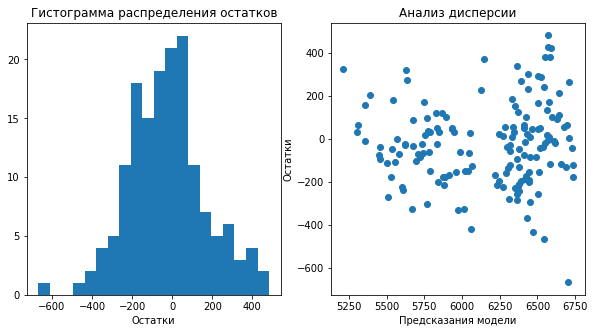

In [54]:
# проведем анализ остатков
# перед этим рассчитаем остатки
residuals_2 = y_test - predictions_2

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_2, bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_2, residuals_2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Значение R² второй модели = 0.819, то есть примерно в 82% случаев предсказание модели ближе к истинному значению, чем среднее значение целевого признака.
Вторая модель показывает более хорошую обобщающую способность, чем первая модель. 

На графике распределения остатков видим, что распределение нормальное, сумма остатков близка к нулю, то есть модель достаточно хорошо работает. 

По графику дисперсии видим, что разница между минимумом и максимумом остатков на высоких прогнозных значениях больше, чем на низких значениях прогноза. 

Можно также попробовать добавить в модель дополнительные признаки или трансформировать данные, чтобы изменить взаимосвязь входных признаков с целевым. 

### Третья модель линейной регрессии

Добавим в данные новый признак - имя папы-быка и обучим на них третью модель линейной регрессии. 

In [55]:
#добавляем новый признак
ferma_main = ferma_main.merge(ferma_dad, on='id')

In [56]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42

# выделяем в отдельные переменные целевой признак и входные признаки
X = ferma_main.drop(['удой'], axis=1)
y = ferma_main['удой']

# разделим данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

ferma_main

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,спо_01,эке_квадрат,сахар,имя_папы
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.58,3.076,вкусно,более_2_лет,меньше_0.92,201.64,1551.270,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,3.54,3.079,вкусно,менее_2_лет,меньше_0.92,163.84,1902.820,Соловчик
2,3,5810,14.0,1854,0.885,Рефлешн Соверинг,холмистое,Рефлешн Соверинг,3.59,3.074,не вкусно,более_2_лет,меньше_0.92,196.00,1640.790,Барин
3,4,5895,12.4,2012,0.885,Рефлешн Соверинг,холмистое,Вис Бик Айдиал,3.40,3.075,не вкусно,более_2_лет,меньше_0.92,153.76,1780.620,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,3.73,3.073,вкусно,менее_2_лет,меньше_0.92,163.84,1482.375,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625,6812,15.4,1964,0.940,Рефлешн Соверинг,равнинное,Вис Бик Айдиал,3.74,3.075,не вкусно,более_2_лет,больше_0.92,237.16,1846.160,Буйный
624,626,5513,12.9,1700,0.880,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,3.64,3.073,вкусно,менее_2_лет,меньше_0.92,166.41,1496.000,Барин
625,627,5970,14.4,1837,0.880,Рефлешн Соверинг,холмистое,Рефлешн Соверинг,3.64,3.075,не вкусно,более_2_лет,меньше_0.92,207.36,1616.560,Барин
626,628,5746,13.8,1994,0.890,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,3.64,3.077,вкусно,более_2_лет,меньше_0.92,190.44,1774.660,Барин


In [57]:
#разделим отобранные признаки на категориальные и количественные
num_col_names = ['эке_квадрат', 'сырой_протеин', 'сахар']
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_01', 'имя_папы']

Масштабируем количественные признаки с помощью StandardScaler

In [58]:
#создаем переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

#обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

#выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[num_col_names])


Кодируем категориальные признаки с помощью OneHotEncoder.

In [59]:
#создаем переменную с экземпляром класса OneHotEncoder()
encoder = OneHotEncoder(drop='first', sparse=False)

#обучим и трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

#выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[cat_col_names])

#получим от кодировщика список новых столбцов 
encoder_col_names = encoder.get_feature_names()

Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

In [60]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

#объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#проверим изменения
X_train[:5]

,x0_Рефлешн Соверинг,x1_холмистое,x2_Рефлешн Соверинг,x3_менее_2_лет,x4_меньше_0.92,x5_Буйный,x5_Геркулес,x5_Соловчик,эке_квадрат,сырой_протеин,сахар
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.577968,1.079523,1.152953
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-1.511438,-0.196920,-0.385570
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.082269,-1.386085,-1.416749
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.150235,0.752230,0.876967
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.102358,0.828598,0.433188


Обучим модель линейной регрессии на подготовленных данных.

In [61]:
#инициализируем модель линейной регрессии
model_lr_3  = LinearRegression()

#обучим модель на тренировочных данных
model_lr_3.fit(X_train, y_train)

#получим предсказания модели на тестовых данных 
predictions_3 = model_lr_3.predict(X_test)


In [62]:
r2_3 = r2_score(y_test, predictions_3)
print(f'R2 LinearRegression = {r2_3:.3f}')

R2 LinearRegression = 0.827


In [63]:
mse_3 = mean_squared_error(y_test, predictions_3)
print(f'MSE LinearRegression = {mse_3:.3f}')

MSE LinearRegression = 35197.049


In [64]:
rmse_3 = mean_squared_error(y_test, predictions_3, squared=False)
print(f'RMSE LinearRegression = {rmse_3:.3f}')

RMSE LinearRegression = 187.609


In [65]:
mae_3 = mean_absolute_error(y_test, predictions_3)
print(f'MAE LinearRegression = {mae_3:.3f}')

MAE LinearRegression = 145.741


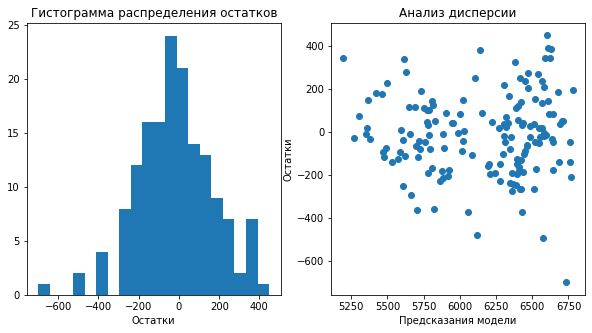

In [66]:
# проведем анализ остатков
# перед этим рассчитаем остатки
residuals_3 = y_test - predictions_3

# построим графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals_3, bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_3, residuals_3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Значение R² третьей модели = 0.827, то есть примерно в 83% случаев предсказание модели ближе к истинному значению, чем среднее значение целевого признака. 

На графике распределения остатков видим, что распределение нормальное, сумма остатков близка к нулю, то есть модель достаточно хорошо работает.

По графику дисперсии видим, что разница между минимумом и максимумом остатков на высоких прогнозных значениях все еще больше, чем на низких значениях прогноза.

### Сравнение метрик моделей

Сравним метрики трех моделей

In [67]:
print(
    f'R2 1 модели: {r2_1:.3f}\nR2 2 модели: {r2_2:.3f} \nR2 3 модели: {r2_3:.3f}\n'
    f'\n'
    f'MSE 1 модели: {mse_1:.3f}\nMSE 2 модели: {mse_2:.3f} \nMSE 3 модели: {mse_3:.3f}\n' 
    f'\n'
    f'RMSE 1 модели: {rmse_1:.3f}\nRMSE 2 модели: {rmse_2:.3f} \nRMSE 3 модели: {rmse_3:.3f}\n'
    f'\n'
    f'MAE 1 модели: {mae_1:.3f}\nMAE 2 модели: {mae_2:.3f} \nMAE 3 модели: {mae_3:.3f}\n'
     )

R2 1 модели: 0.784
R2 2 модели: 0.819 
R2 3 модели: 0.827

MSE 1 модели: 43887.015
MSE 2 модели: 36892.861 
MSE 3 модели: 35197.049

RMSE 1 модели: 209.492
RMSE 2 модели: 192.075 
RMSE 3 модели: 187.609

MAE 1 модели: 164.242
MAE 2 модели: 148.717 
MAE 3 модели: 145.741



Видим, что лучшие показатели метрик показывает третья модель, дисперсия остатков у этой модели так же более равномерное, чем у остальных двух моделей. 

Укажем доверительный интервал прогноза третьей модели. 

In [68]:
print(f'Доверительный интервал прогноза 95%: [{np.quantile(predictions_3, 0.025)}, {np.quantile(predictions_3, 0.975)}]')

Доверительный интервал прогноза 95%: [5361.099689830322, 6736.787140680805]


### Прогноз удоя коров

Добавим недостающие признаки в датасет cow_buy ЭКЕ, Сырой протеин и СПО увеличив средние значения датасета ferma_main.csv каждого из признаков на 5%.

In [69]:
for col_name in ['эке', 'сырой_протеин', 'спо']:
    cow_buy[col_name] = ferma_main[col_name].mean() * 1.05

#проверим изменения
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо
0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744
1,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744
2,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744
3,Рефлешн Соверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744
4,Рефлешн Соверинг,равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744


Выполним подготовку данных, аналогичную той, которую делали для тренировочной выборки.

In [70]:
cow_buy['эке_квадрат'] = cow_buy['эке'].apply(lambda x: x**2)
cow_buy['спо_01'] = cow_buy['спо'].apply(lambda x: 'меньше_0.92' if x < 0.92 else 'больше_0.92')
cow_buy['сахар'] = cow_buy['спо'] * cow_buy['сырой_протеин']

#выделяем в отдельные переменные целевой признак и входные признаки
X_test = cow_buy
X_train = ferma_main.drop(['удой'], axis=1)
y_train = ferma_main['удой']

In [71]:
num_col_names = ['эке_квадрат', 'сырой_протеин', 'сахар']
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_01', 'имя_папы']

Масштабируем количественные признаки с помощью StandardScaler

In [72]:
#выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[num_col_names])

Кодируем категориальные признаки с помощью OneHotEncoder

In [73]:
#выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[cat_col_names])

#получим от кодировщика список новых столбцов 
encoder_col_names = encoder.get_feature_names()

Cоздаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

In [74]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

#объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#проверим изменения
X_train[:5]

,x0_Рефлешн Соверинг,x1_холмистое,x2_Рефлешн Соверинг,x3_менее_2_лет,x4_меньше_0.92,x5_Буйный,x5_Геркулес,x5_Соловчик,эке_квадрат,сырой_протеин,сахар
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.577968,1.079523,1.152953
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-1.511438,-0.196920,-0.385570
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.082269,-1.386085,-1.416749
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.150235,0.752230,0.876967
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.102358,0.828598,0.433188


In [75]:
#получим предсказания модели 
predictions_fin = model_lr_3.predict(X_test)

cow_buy['прогноз_удоя'] = predictions_fin

cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо,эке_квадрат,спо_01,сахар,прогноз_удоя
0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6640.519608
1,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6408.220807
2,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6305.755318
3,Рефлешн Соверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6622.014508
4,Рефлешн Соверинг,равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6566.895135


## Обучение модели логистической регрессии

Необходимо подготовить данные датасета ferma_main.csv и обучить на них модель логистической регрессии. 
Используем в качестве целевого признак Вкус молока.

### Модель логистической регрессии

Заменим значения целевого признака на 1 и 0. 

In [76]:
ferma_main['вкус_молока_01'] = ferma_main['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)

In [77]:
#создание константы RANDOM_STATE
RANDOM_STATE = 42

#выделяем в отдельные переменные целевой признак и входные признаки
X = ferma_main.drop(['вкус_молока_01'], axis=1)
y = ferma_main['вкус_молока_01']

#разделим данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

In [78]:
num_col_names = ['эке_квадрат','сырой_протеин','белок', 'сахар', 'жирность']
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'возраст', 'спо_01']

Масштабируем количественные признаки с помощью StandardScaler

In [79]:
#создаем переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

#обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

#выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[num_col_names])

Кодируем категориальные признаки с помощью OneHotEncoder

In [80]:
#создаем переменную с экземпляром класса OneHotEncoder()
encoder = OneHotEncoder(drop='first', sparse=False)

#обучим и трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

#выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[cat_col_names])

#получим от кодировщика список новых столбцов 
encoder_col_names = encoder.get_feature_names()

Cоздаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

In [81]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

#объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#проверим изменения
X_train[:5]

,x0_Рефлешн Соверинг,x1_холмистое,x2_Рефлешн Соверинг,x3_Буйный,x3_Геркулес,x3_Соловчик,x4_менее_2_лет,x5_меньше_0.92,эке_квадрат,сырой_протеин,белок,сахар,жирность
0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.577968,1.079523,-0.679069,1.152953,0.562532
1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.511438,-0.196920,-1.452568,-0.385570,-1.601817
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.082269,-1.386085,1.254677,-1.416749,-2.563750
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.150235,0.752230,1.254677,0.876967,0.081565
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.102358,0.828598,0.094429,0.433188,0.201807


In [82]:
#инициализируем модель логистической регрессии
clf = LogisticRegression()

#обучим модель на тренировочных данных
clf.fit(X_train, y_train)

#получим предсказания модели на тестовых данных 
y_pred = clf.predict(X_test)

Оценим качество модели на тестовой выборке: рассчитаем метрики accuracy, recall, precision. 

In [83]:
accuracy = accuracy_score(y_test, y_pred)
f'Accuracy: {accuracy:.3f}'

'Accuracy: 0.656'

In [84]:
recall = recall_score(y_test, y_pred)
f'Recall: {recall:.3f}'

'Recall: 0.886'

In [85]:
precision = precision_score(y_test, y_pred)
f'Precision: {precision:.3f}'

'Precision: 0.639'

Построим матрицу ошибок

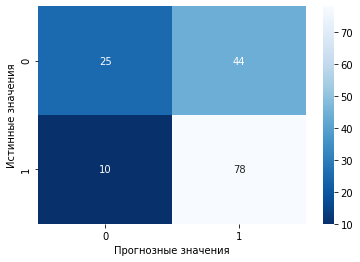

In [86]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Прогнозные значения');

Модель показывает достаточно невысокое значение accuracy - примерно 65% правильных предсказаний в выборке. 
При этом модель имеет высокий показатель полноты - recall - модель выделяет практически 89% правильных предсказаний вкусного молока из всех значений. 

При покупке коров критичнее всего ошибка первого рода - так как необходимо отобрать коров со вкусным молоком. 
То есть необходимо свести к минимуму ошибки false positive и повысить точность precision до максимума. 

Подберем новое значение порога с учетом сведения к минимуму ошибки false positive

In [87]:
#создаём переменную, которая будет хранить список новых колонок
columns = []

#создадим функцию для подбора порога
def threshold_track(thresholds, df):
    data_fin = pd.DataFrame(columns=['порог', 'precision', 'recall', 'true_positive', 'false_positive', 'false_negative'])
    for i in thresholds:
        columns.append('y_pred_'+str(i))
        df['y_pred_'+str(i)] = df['y_proba'].apply(lambda x:0 if x < i else 1)
        precision = precision_score(df['y_valid'], df['y_pred_'+str(i)])
        recall = recall_score(df['y_valid'], df['y_pred_'+str(i)])
        fp = df[(df['y_pred_'+str(i)] == 1) & (df['y_valid'] == 0)].shape[0]
        fn = df[(df['y_pred_'+str(i)] == 0) & (df['y_valid'] == 1)].shape[0]
        tp = df[(df['y_pred_'+str(i)] == 1) & (df['y_valid'] == 1)].shape[0]
        data_fin = data_fin.append({
            'порог': 'y_pred_'+str(i),
            'precision': precision,
            'recall': recall,
            'true_positive': tp,
            'false_positive': fp,
            'false_negative': fn
        }, ignore_index=True)
    return data_fin


In [88]:
#подготовим датасет со значениями вероятности и истинных значений
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

#подготовим значения порогов
thresholds = [round(i,2) for i in np.linspace(0.65, 0.82, num = 16, endpoint=False)]

#произведем подбор
threshold_track(thresholds, data)

,порог,precision,recall,true_positive,false_positive,false_negative
0,y_pred_0.65,0.791667,0.647727,57,15,31
1,y_pred_0.66,0.809524,0.579545,51,12,37
2,y_pred_0.67,0.806452,0.568182,50,12,38
3,y_pred_0.68,0.781818,0.488636,43,12,45
4,y_pred_0.69,0.795918,0.443182,39,10,49
5,y_pred_0.7,0.826087,0.431818,38,8,50
6,y_pred_0.71,0.837209,0.409091,36,7,52
7,y_pred_0.72,0.810811,0.340909,30,7,58
8,y_pred_0.74,0.823529,0.318182,28,6,60
9,y_pred_0.75,0.827586,0.272727,24,5,64


Видим, что при значении порога 0.8 ошибки первого рода сводятся к нулю. Значение recall - 0.11 и precision - 1.0. 
С помощью вычисленного порога сделаем прогноз вкуса молока коров для покупки. 

### Прогноз вкуса молока коров для покупки

Выполним подготовку данных, аналогичную той, которую делали для тренировочной выборки.

In [89]:
#выделяем в отдельные переменные целевой признак и входные признаки
X_test = cow_buy
X_train = ferma_main.drop(['вкус_молока_01'], axis=1)
y_train = ferma_main['вкус_молока_01']

In [90]:
num_col_names = ['эке_квадрат','сырой_протеин','белок', 'сахар', 'жирность']
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'возраст', 'спо_01']

Масштабируем количественные признаки с помощью StandardScaler

In [91]:
#выполним преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[num_col_names])

Кодируем категориальные признаки с помощью OneHotEncoder

In [92]:
#выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[cat_col_names])

#получим от кодировщика список новых столбцов 
encoder_col_names = encoder.get_feature_names()

Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

In [93]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

#объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#проверим изменения
X_train[:5]

,x0_Рефлешн Соверинг,x1_холмистое,x2_Рефлешн Соверинг,x3_Буйный,x3_Геркулес,x3_Соловчик,x4_менее_2_лет,x5_меньше_0.92,эке_квадрат,сырой_протеин,белок,сахар,жирность
0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.577968,1.079523,-0.679069,1.152953,0.562532
1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.511438,-0.196920,-1.452568,-0.385570,-1.601817
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.082269,-1.386085,1.254677,-1.416749,-2.563750
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.150235,0.752230,1.254677,0.876967,0.081565
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.102358,0.828598,0.094429,0.433188,0.201807


In [94]:
#получим предсказания модели с учетом порога 

y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.8).astype(int)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
cow_buy['вкус_молока_прогноз'] = y_pred
cow_buy['вкус_молока_прогноз'] = cow_buy['вкус_молока_прогноз'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')
cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо,эке_квадрат,спо_01,сахар,прогноз_удоя,вкус_молока_прогноз
0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6640.519608,не вкусно
1,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6408.220807,не вкусно
2,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6305.755318,не вкусно
3,Рефлешн Соверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6622.014508,не вкусно
4,Рефлешн Соверинг,равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6566.895135,не вкусно
5,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6453.705937,не вкусно
6,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6640.519608,не вкусно
7,Вис Бик Айдиал,равнинное,Рефлешн Соверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6599.465449,не вкусно
8,Рефлешн Соверинг,равнинное,Рефлешн Соверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6305.755318,не вкусно
9,Рефлешн Соверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6430.769866,вкусно


С учетом нового порога для минимизации ошибок первого рода модель спрогнозировала одну корову с вкусным молоком. 

## Итоговые выводы

In [96]:
#выведем список коров к покупке
cow_buy.query('вкус_молока_прогноз == "вкусно" and прогноз_удоя > 6000')

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо,эке_квадрат,спо_01,сахар,прогноз_удоя,вкус_молока_прогноз
9,Рефлешн Соверинг,холмистое,Вис Бик Айдиал,Буйный,3.4,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,больше_0.92,1936.61183,6430.769866,вкусно


В ходе проекта была решена задача по разработке двух моделей машинного обучения для отбора бурёнок в поголовье.

Проект был разделен на несколько этапов:
1. Загрузка данных - загрузили три датасета, при общем осмотре данных заметили нестандратное название в столбцах, исправили наименования на змеиный регистр. Типы данных в датасетах соотвествовали ожидаемым, пропусков в данных не было.  


2. Предобработка данных - здесь были обнаружены явные и неявные дубликаты в датасетах (в названиях пород, типах пастбищ), были удалены и заменены все дубликаты, но в датасете с информацией о коровах к покупке было решено оставить дубликаты без изменений.    


3. Исследовательский анализ данных - были построены графики распределения количественных и категориальных признаков в выборке. Распределения ЭКЕ и белка похожи на нормальные, есть небольшое смещение (влево и вправо). Графики распредления сырого протеина и СПО не похожи на нормальные, необходимо изменить признаки для улучшения связи с целевым признаком.
    
    Замечены выбросы в целевом признаке - удое, а также в значениях белка, жирности молока коров. Были основания полагать, что модель будет плохо работать с данными о высоких показаниях удоя (для прогнозов высокого удоя необходимо больше данных о таких показателях в стаде), а также с данными о молодых коровах - так как их достаточно мало относительно других записей в датасете. Аномальное значение удоя было удалено. Выбросы в столбцах белка и жирности оставили для последующего анализа.   
    

4. Корреляционный анализ - был построен график со значениями корреляции признаков, расчет производился по методу Спирмана, так как распределения некоторых признаков было ненормальным, по нему можно отметить наличие высокой связи между удоем и ЭКЕ, СПО. Заметная связь между удоем и жирностью молока, умеренная - между удоем и сырым протеином в корме коров. Отсутствует связь между белком и удоем молока. Существует высокий уровень связи между показателями ЭКЕ и СПО, умеренный - между ЭКЕ, СПО и жирностью молока. В общем можно отметить, что между входными признаками нет мультиколиннеарности.  

    На диаграммах рассеяния увидели, что связь между удоем и количественными признаками не линейная, между ЭКЕ и удоем видим график связи, похожий график квадратичной функции. График СПО и жирности молока похож на график категориального признака. Нет различий в взаимосвязях для разных пород.
    Коровы, обитающие на холмистых пастбищах дают более высокие показатели удоя при практически равных показателях питания и жирности молока. Но характер связи с удоем все еще не различается для разных типов пастбищ.
    Для молодых коров будет сложно предсказать показатели удоя и вкуса молока - так как взаимосвязь с другими признаками не прослеживается.
    Связи с целевым признаком в общем нелинейные, необходимо ввести новые признаки или транформировать текущие для приближения связи к линейной.  
    

5. Обучение модели линейной регрессии - были построены три модели для прогноза удоя :
    * первая модель - были выбраны следующие признаки : ЭКЕ, СПО, сырой протеин - признаки, связанные с кормом - могут напрямую влиять на размер удоя. Порода, порода папы-быка и возраст - биологические признаки, которые могут как напрямую так и наследственно влиять на размер удоя. Тип пастбища - увидели на диаграмме рассеяния, что этот признак также неким образом связан с удоем. Признаки, связанные с молоком отбросили: белок, жирность, не могут влиять на удой, так как эти признаки являются уже следствием удоя молока.
    * вторая модель - попробовали исключить нелинейность связей признаков с целевым. Преобразовали СПО в категориальный бинарный признак, использовав границу между двумя кластерами из диаграммы рассеяния. Также ввели два новых признака: ЭКЕ в квадрате и сахар состава корма.
    * третья модель - был введен новый признак - имя папы-быка. 
    
   После обучения моделей был проведен анализ остатков, построены графики распределения и диаграммы рассеяния.
   Посчитаны метрики для анализа качества прогнозов. 
   Как и предполагалось, на графиках рассеяния всех моделей замечено, что разница между минимумом и максимумом остатков на высоких прогнозных значениях все еще больше, чем на низких значениях прогноза. То есть модели ошибаются сильнее на значениях с высоким удоем - так как этих данных мало для анализа и обучения модели в выборке. Но графики распределения нормальные, без смещений, модели показали хорошие показатели:

    * R2 1 модели: 0.784
    * R2 2 модели: 0.819 
    * R2 3 модели: 0.827

    * MSE 1 модели: 43887.015
    * MSE 2 модели: 36892.861 
    * MSE 3 модели: 35197.049

    * RMSE 1 модели: 209.492
    * RMSE 2 модели: 192.075 
    * RMSE 3 модели: 187.609

    * MAE 1 модели: 164.242
    * MAE 2 модели: 148.717 
    * MAE 3 модели: 145.741

   Значение R² третьей модели = 0.827, то есть примерно в 83% случаев предсказание модели ближе к истинному значению, чем среднее значение целевого признака.
   Остальные метрики также имеют лучшие результаты среди моделей. Поэтому как лучшую выбрали третью модель. 

   Можно сделать вывод о том, что приближение связей к линейным между входящими признаками и целевым, а также ввод новых признаков улучшает качество регрессионной модели. Но также важно иметь большую дисперсию целевого признака в выборке для обучения, чтобы модель предсказывала значения целевого признака для низких и высоких значений одинаково точно. 

   Далее был произведен прогноз удоя коров на данных датасета с коровами к покупке. 
   

6. Обучение модели логистической регрессии - модель с прогнозом целевого признака - вкус молока. 
    Входящие признаки оставили с исправлением нелинейной связи, а также с добавленными новыми признаками - сахар и имя папы-быка. За целевое - 1 для вкусного молока и 0 для невкусного молока. 

    Модель показывает достаточно невысокое значение accuracy - примерно 65% правильных предсказаний в выборке. При этом модель имеет высокий показатель полноты - recall - модель выделяет практически 89% правильных предсказаний вкусного молока из всех значений.

    При покупке коров критичнее всего ошибка первого рода - так как необходимо отобрать коров со вкусным молоком. То есть необходимо свести к минимуму ошибки false positive и повысить точность precision до максимума.
    Подобрали новое значение порога с учетом сведения к минимуму ошибки false positive - 0.8
    Значение recall - 0.11 и precision - 1.0. С помощью вычисленного порога провели прогноз вкуса молока коров для покупки.

    Для анализа рисков важны такие метрики как точность и полнота, выбрав ошибку, которую нужно свести к минимуму и соответственно повысив ту или иную метрику, можно добиться минимизации экономических потерь. 
    
    
7. Общий вывод:
    При заданных условиях к покупке: удой более 6000 килограммов в год и вкусное молоко, результат работы моделей - одна корова. 

    В результате проверки трех моделей для прогноза удоя была отобрана третья - с лучшими показателями метрик. 
    Для прогноза вкуса молока коров было подобрано значение порога, для того, чтобы целевой признак был точно предсказан моделью. 

    Фермер может приобрести их с минимальным риском для себя - коровы с точностью дадут вкусное молоко и с вероятностью 83% удой будет свыше 6000 кг/год.

    Рекомендации по улучшению моделей:
    Для улучшения показателей прогноза можно:
    - добавить больше данных по высоким показателям удоя - тогда мы повысим дисперсию таргета и модель линейной регрессии будет давать прогноз с хорошими показателями. 
    - добавить новые признаки - например, признаки, связанные с показателями корма для коров или более точно определить их возраст - таким образом сможем повысить качество модели классификации (сейчас accuracy = 65%)